## ECG Classification using Deep Learning

**INTRODUCTION**

this project is to predict different arrhytmia type on ECG.
#### Dataset
The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample. souces : https://physionet.org/content/mitdb/1.0.0/

Arrhythmia Dataset
Data Source: Physionet's MIT-BIH Arrhythmia Dataset

To simplify the problem, we will assume that a QRS detector is capable of automatically identifying the peak of each heart beat. We will ignore any non-beat annotations and any heart beats in the first or last 3 seconds of the recording due to reduced data. We will use a window of 6 seconds so we can compare the current beat to beats just before and after. This decision was based after talking to a physician who said it is easier to identify if you have something to compare it to. 

# Data Preparation

## Read Dataset 



importing requirment 

write the following to install wfdb and biosppy 
```python
!pip install wfdb
```

In [ ]:
!pip install wfdb

In [1]:
!pip install biosppy

     |████████████████████████████████| 76 kB 462 kB/s eta 0:00:01
  Using cached shortuuid-1.0.1-py3-none-any.whl (7.5 kB)
     |████████████████████████████████| 2.9 MB 373 kB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.


In [1]:
!pip install biosignalsnotebooks



     |████████████████████████████████| 39.1 MB 970 kB/s eta 0:00:01
     |████████████████████████████████| 16.0 MB 838 kB/s eta 0:00:01
     |████████████████████████████████| 334 kB 878 kB/s eta 0:00:01
     |████████████████████████████████| 10.6 MB 732 kB/s eta 0:00:01
     |████████████████████████████████| 7.2 MB 479 kB/s eta 0:00:01
     |████████████████████████████████| 30.7 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 60 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 785 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 10.4 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 227 kB 2.7 MB/s eta 0:00:01
  Using cached Jinja2-2.11.3-py2.py3-none-any.whl (125 kB)
  Using cached packaging-20.9-py2.py3-none-any.whl (40 kB)
     |████████████████████████████████| 416 kB 1.8 MB/s eta 0:

  Created wheel for libmagic: filename=libmagic-1.0-py3-none-any.whl size=4287 sha256=3e2b07f8c0d19f183658396746a13ef39c259944bdf605434a47e560ada46bf7
  Stored in directory: /Users/youssefabbas/Library/Caches/pip/wheels/1f/09/8f/b428f254d5cdbe8b9b158355f5bc10119dc4914e0b22852aaa
  Created wheel for pyrsistent: filename=pyrsistent-0.17.3-cp37-cp37m-macosx_10_9_x86_64.whl size=68365 sha256=a1c0da991e07f6101f6fdab3440d0f86b0ee6264943e6587e24b71128be5b570
  Stored in directory: /Users/youssefabbas/Library/Caches/pip/wheels/a5/52/bf/71258a1d7b3c8cbe1ee53f9314c6f65f20385481eaee573cc5
Successfully built bokeh libmagic pyrsistent


# import requirments 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import wfdb
from biosppy.signals import ecg , tools
import scipy

import biosignalsnotebooks as bsnb


You should download that that is it first from [Physionet's MIT-BIH](https://physionet.org/content/mitdb/1.0.0/)

# Dataset Path

In [2]:
data_path = '../../mit-bih-arrhythmia-database-1.0.0/'


here is the list of patients in the dataset 

## Classes
this is the 5 type of rythmia that we will calssification 
there is 21 records 

In [3]:
NOR = ['100','101','105','108','113','115','116'] #total : ~16270
AP = ['209','222','232']#total : ~1974
LBBB = ['109','111','207']#total : ~8075
RBBB = ['118','124','212','231']#total : ~6776
PVC = ['233','228','221','217','203','200','119','106']#total : ~3185


load all the annotations and see the distribution of heart beat types across all files. 
for more Details [see more about annotation](https://archive.physionet.org/physiobank/database/html/mitdbdir/intro.htm#annotations)

In [4]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?','f','F','j','a','J','e','S','E','/']
#? 5 Types 
classification = ['N','L','R','V','A'] 

# Segmentation 
here we calculate the distance between each R-Peack i nthe signal then segment raw signal in classes 
In the MIT-BIH arrhythmia database, every
ECG beat is sliced based on Q-wave peak time

In [71]:
def segmentation(records,good):
    Normal = []
    for e in records:
        signals, fields = wfdb.rdsamp(data_path+e, channels = [0]) 
        ann = wfdb.rdann(data_path+e, 'atr')
        ids = np.in1d(ann.symbol, good)
        imp_beats = ann.sample[ids]
        beats = (ann.sample)
        for i in imp_beats:
            beats = list(beats)
            j = beats.index(i)
            if(j!=0 and j!=(len(beats)-1)):
                x = beats[j-1]
                y = beats[j+1]
                diff1 = abs(x - beats[j])//2
                diff2 = abs(y - beats[j])//2
                Normal.append(signals[beats[j] - diff1: beats[j] + diff2, 0])
    return Normal

In [72]:
sig_nor = segmentation(NOR,'N')

In [82]:
sig_AP = segmentation(AP,'A')

In [85]:
sig_LBBB = segmentation(LBBB,'L')

In [86]:
sig_RBBB = segmentation(RBBB,'R')

In [87]:
sig_PVC = segmentation(PVC,'V')

In [92]:
len(sig_AP[66])

140

In [120]:
n = []
a = []
p = []
l = []
r = []

In [121]:
for i in sig_nor : 
    si = scipy.signal.resample(i, 360)
    zscore = scipy.stats.zscore(si)
    n.append(zscore.tolist())

In [122]:
for i in sig_AP : 
    si = scipy.signal.resample(i, 360)
    zscore = scipy.stats.zscore(si)
    
    a.append(zscore.tolist())

In [123]:
for i in sig_LBBB : 
    si = scipy.signal.resample(i, 360)
    zscore = scipy.stats.zscore(si) 
    l.append(zscore.tolist())

In [124]:
for i in sig_RBBB : 
    si = scipy.signal.resample(i, 360)
    zscore = scipy.stats.zscore(si)   
    r.append(zscore.tolist())

In [125]:
for i in sig_PVC : 
    si = scipy.signal.resample(i, 360)
    zscore = scipy.stats.zscore(si)   
    p.append(zscore.tolist())

In [147]:
len(n)

14401

In [172]:
import csv
for_example = n
with open('output.csv', 'w', newline='') as csv_1:
  csv_out = csv.writer(csv_1)
  csv_out.writerows([for_example[index]] for index in range(0, len(for_example)))


In [173]:
n[1]

[0.2831493717683531,
 0.22567901233539708,
 0.1792003015568714,
 0.15123791728381794,
 0.13065630765214334,
 0.20688263278567665,
 0.22565850406211058,
 0.27464313335289653,
 0.24378421507808304,
 0.15707343055571596,
 0.17882546881924466,
 0.15198731473032742,
 0.17951165329542107,
 0.21840492642482015,
 0.20388322201896977,
 0.2687023947024293,
 0.23239474201180085,
 0.15525356062019155,
 0.13677303301182758,
 0.12344239275903214,
 0.20022249555751342,
 0.1999658450185379,
 0.1459654396653441,
 0.1828284416618315,
 0.12701577966340133,
 0.05842043673388112,
 0.06915816819115837,
 0.04392268016473016,
 0.07409564291540117,
 0.1041678510783462,
 0.039279355371373566,
 0.01619463793303555,
 0.01598315010866514,
 0.028466456930221512,
 0.07861845539147302,
 0.11129472677325772,
 0.1606033224024438,
 0.14865150507528047,
 0.11860130240630899,
 0.12717210388510078,
 0.038394498721299616,
 0.03645578144800195,
 0.12622470845961986,
 0.10290815028136109,
 0.07486119153496211,
 0.053616838738

In [174]:
df = pd.DataFrame(n)
df.to_csv('file3.csv', index=False, header=False)


In [141]:
df = pd.DataFrame(a)
df.to_csv('a.csv', index=False, header=False)


In [142]:
df = pd.DataFrame(l)
df.to_csv('l.csv', index=False, header=False)


In [143]:
df = pd.DataFrame(r)
df.to_csv('r.csv', index=False, header=False)


In [144]:
df = pd.DataFrame(p)
df.to_csv('p.csv', index=False, header=False)


make data balanced 

In [130]:
dfn = pd.DataFrame(n)
dfn['target'] = 0


In [131]:
dfa = pd.DataFrame(a)
dfa['target'] = 1


In [132]:
dfl = pd.DataFrame(l)
dfl['target'] = 2


In [133]:
dfr = pd.DataFrame(r)
dfr['target'] = 3


In [134]:
dfp = pd.DataFrame(p)
dfp['target'] = 4


In [135]:
from sklearn.utils import resample
dfa_upsample=resample(dfa,replace=True,n_samples=6320)
dfn_downsample=resample(dfn,replace=True,n_samples=8600)

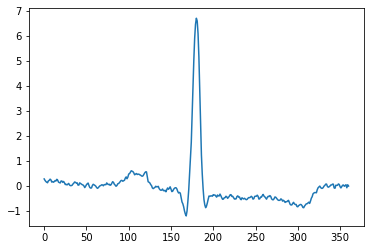

In [182]:
plt.plot(dfn.values[1])

In [136]:
train_df=pd.concat([dfn_downsample,dfa_upsample,dfl,dfr,dfp])

In [159]:
train_df=pd.concat([dfn,dfa,dfl,dfr,dfp])

In [160]:
train_df.target.value_counts()

0    14401
3     6773
2     6070
4     3985
1     1972
Name: target, dtype: int64

In [161]:
import threading


In [162]:
csv_output_lock = threading.Lock()


In [163]:
train_df.to_csv('MIT-BIH arrythmia dataset with 21 record 5 class dataset using R-peack header=True.csv',index=False)

In [145]:
train_df.to_csv('MIT-BIH arrythmia dataset with 21 record 5 class sampled dataset using R-peack header=True.csv',index=False)

In [165]:
train_df.info(verbose=False, memory_usage="deep")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 31748 entries, 5500 to 3984
Columns: 361 entries, 0 to target
dtypes: float64(360), int64(1)
memory usage: 87.7 MB
